1. Installing required modules

In [1]:
# Installs required modules
!pip install --upgrade watermark blackcellmagic
!pip install datasets
!pip install transformers
!pip install "ray[tune]"

2. Importing required modules

In [1]:
# Loads Black extension and imports required modules
%load_ext blackcellmagic

import torch
import torchtext
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import set_seed
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import json
import os
import shutil
from joblib import dump, load
import re 
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Sets seeds to zero
set_seed(0)
torch.manual_seed(0)
np.random.seed(0)

3. Defining utility functions for the entire project

In [2]:
def prepare_dataset(working_dir=os.getcwd()):
  """This function prepares and returns the dataset for the project.

  Arguments
  ---------
  working_dir : str
    A string value representing the current working directory 
  
  Returns
  ---------
  project_dataset : datasets.Dataset
    A Dataset object containing the train, validation, and test data
  """

  train_file = working_dir + "/train_dataset_processed.csv"
  test_file = working_dir + "/test_dataset_processed.csv"

  data_files = {"train": train_file, "test": test_file}
  class_names = ["negative", "neutral", "positive"]
  data_columns = Features({"label": ClassLabel(names=class_names), "text": Value("string")})
  original_data = load_dataset("csv", data_files=data_files, column_names=["label", "text"], features=data_columns)

  train_valid_data = original_data["train"].train_test_split(test_size=0.2)
  train_dataset = train_valid_data["train"]
  valid_dataset = train_valid_data["test"]
  project_dataset = DatasetDict({
      "train": train_dataset,
      "valid": valid_dataset,
      "test": original_data["test"]})

  # Removing empty text entries
  project_dataset = project_dataset.filter(lambda example: example["text"] != None)
  return project_dataset


def plot_confusion_matrix(y_preds, y_true, labels, title):
  """This function displays the confusion matrix for provided predictions by a classifier.

  Arguments
  ---------
  y_preds : numpy.ndarray
    Predictions by a classifier
  y_true : numpy.ndarray
    Labels corresponding to the predictions in y_preds
  labels : list
    Label names to be used for the confusion matrix
  title : str
    Title to be used for the confusion matrix

  """

  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix for " + title)
  plt.show()

def print_classification_report(y_preds, y_true, title):
  """This function displays the classification report for provided predictions by a classifier.

  Arguments
  ---------
  y_preds : numpy.ndarray
    Predictions by a classifier
  y_true : numpy.ndarray
    Labels corresponding to the predictions in y_preds
  title : str
    Title to be used for the confusion matrix

  """

  labels = ["negative", "neutral", "positive"]
  plot_confusion_matrix(y_preds, y_true, labels, title)
  print("\n")
  print("Classification report for " + title)
  acc = accuracy_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds, average="weighted")
  prec = precision_score(y_true, y_preds, average="weighted")
  rec = recall_score(y_true, y_preds, average="weighted")
  
  print("-" * 75)
  print("Accuracy: %.2f%%" % (acc * 100))
  print("Precision: %.2f%%" % (prec * 100) )
  print("Recall: %.2f%%" % (rec * 100))
  print("F1 score: %.2f%%" % (f1 * 100) )
  print("-" * 75)
  print("\n\n")

def display_data_properties(dataset):
  """This function displays data distribution among different classes in the dataset.

  Arguments
  ---------
  dataset : datasets.Dataset
    A Dataset object containing one or more of the following -  train, validation, and test data

  """

  # Uses pandas to display the data distribution
  dataset.set_format(type="pandas")
  train_df = dataset["train"][:]
  valid_df = dataset["valid"][:]
  test_df = dataset["test"][:]

  def label_int2str(row):
    """
    This function converts a label's integer value to a string value.

    Arguments
    ---------
    row : int
      Integer value of the label
    
    """

    return dataset["train"].features["label"].int2str(row)

  train_df["label_name"] = train_df["label"].apply(label_int2str)
  valid_df["label_name"] = valid_df["label"].apply(label_int2str)
  test_df["label_name"] = test_df["label"].apply(label_int2str)

  print("Displaying the first 5 examples of the training dataset: ")
  print("-" * 75)
  print(train_df.head())
  print("-" * 75)

  # Displays the frequency of classes in the training data
  train_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in training data")
  plt.show()

  # Displays the frequency of classes in the validation data
  plt.figure()
  valid_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in validation data")
  plt.show()

  # Displays the frequency of classes in the test data
  plt.figure()
  test_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in test data")
  plt.show()

  # Resetting the dataset format
  dataset.reset_format()

# 2. Transformers section

## 2.1. Completing project setup for transformer models

The below code cell is used to provide the value for "model_checkpoint" as one of the following: "distilbert-base-uncased" or "bert-base-uncased".

This sets the pretrained transformer model to be used for the current execution of the model as either BERT or DistilBERT.

In [11]:
model_checkpoint = "distilbert-base-uncased"

working_dir = os.getcwd()   # Sets the working directory for the project
project_dataset = prepare_dataset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_samples = [9023, 12366, 6416]
class_weights = [1 - (x / sum(class_samples)) for x in class_samples]
class_weights = torch.FloatTensor(class_weights).to(device)

if not os.path.exists(working_dir + "/output-" + model_checkpoint):
  os.makedirs(working_dir + "/output-" + model_checkpoint)
model_output_dir = working_dir + "/output-" + model_checkpoint

if not os.path.exists(working_dir + "/best_models/" + model_checkpoint):
  os.makedirs(working_dir + "/best_models/" + model_checkpoint)

# Instantiates a tokenizer based on the provided name of the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Using custom data configuration default-98ec775250f1e4de


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-98ec775250f1e4de/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Verifying the project setup

In [ ]:
assert isinstance(working_dir, str), "Expected working_dir to be a string value"
assert working_dir == os.getcwd(), "Expected working_dir to be the current working dir"
assert isinstance(class_samples, list), "Expected class_samples to be a list"
assert isinstance(class_weights, torch.Tensor), "Expected class_weights to be a torch.Tensor"
assert model_checkpoint == "distilbert-base-uncased" or model_checkpoint == "bert-base-uncased", "Expected model_checkpoint to be either \"distilbert-base-uncased\" or \"bert-base-uncased\""
assert model_output_dir == working_dir + "/output-" + model_checkpoint, "Unexpected value for model_outpur_dir"

<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>


## 2.2 Preparing input data

2.2.1. Tokenizating the input

In [ ]:
def encode_dataset(tokenizer, project_dataset):
  """This function uses the provided tokenizer to encode project dataset.

  Arguments
  ---------
  tokenizer : 
    The tokenizer intantiated based on the pretrained model being used for the project
  project_dataset : datasets.Dataset
    A Dataset object containing one or more of the samples and their labels
  
  Returns
  ---------
  dataset_encoded : datasets.dataset_dict.DatasetDict
    The encoded samples and their labels
  """
  
  # Initializes the tokenizer
  tokenizer = tokenizer

  # Defines the tokenization function
  def tokenize(batch):
    """This function applies tokenizer to a batch of samples

    Arguments
    ---------
    batch : 
      A batch of samples
    """
    return tokenizer(batch["text"], padding=True, truncation=True)
    
  # Applies the tokenize function to the provided project_dataset
  return project_dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded = encode_dataset(tokenizer, project_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-18544bdb167fe355/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-5299531d32bec648.arrow


## 2.3 Training a classifier

### 2.3.1 Training a classifier using feature extraction

2.3.1.1 Extracting the last hidden states

In [ ]:
def extract_hidden_states_features(model_checkpoint, dataset_encoded):

  model = AutoModel.from_pretrained(model_checkpoint).to(device)

  # Extracting the last hidden states
  def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
      last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

  # Extracting hidden states across all dataset splits in one go
  dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  return dataset_hidden

dataset_hidden = extract_hidden_states_features(model_checkpoint, dataset_encoded)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

2.3.1.2 Creating train, validation, test datasets of the hidden states as required for the classifier

In [ ]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

2.3.1.3 Training an MLP classifier using the hidden states and labels

In [ ]:
mlp = MLPClassifier(random_state=0,
                    validation_fraction=0.2, 
                    early_stopping=True)
mlp.fit(X_train, y_train)
print("Training accuracy: %.2f %%" % (mlp.score(X_train, y_train) * 100))
print("Validation accuracy: %.2f %%"  % (mlp.score(X_valid, y_valid) * 100))

Training accuracy: 54.96 %
Validation accuracy: 47.51 %


2.3.1.4 Generating results to document a baseline

Plots the training loss and validation accuracy of the MLP model

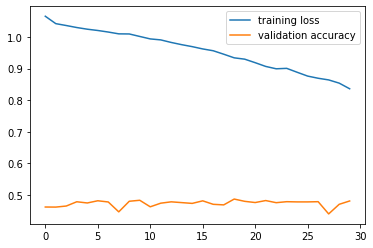

In [ ]:
plt.plot(mlp.loss_curve_, label="training loss")
plt.plot(mlp.validation_scores_, label="validation accuracy")
plt.legend();

Provides the confusion matrix and classification report for validation data and test data of the project

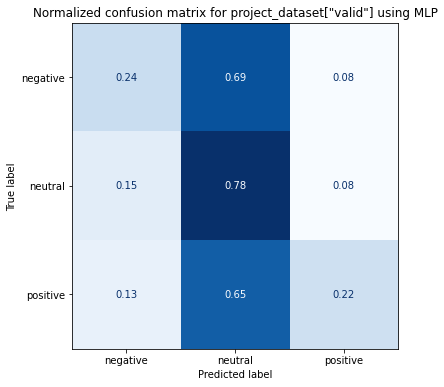



Classification report for project_dataset["valid"] using MLP
---------------------------------------------------------------------------
Accuracy: 47.51%
Precision: 46.83%
Recall: 47.51%
F1 score: 43.60%
---------------------------------------------------------------------------





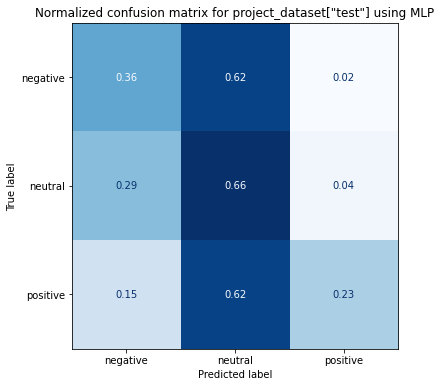



Classification report for project_dataset["test"] using MLP
---------------------------------------------------------------------------
Accuracy: 41.12%
Precision: 54.06%
Recall: 41.12%
F1 score: 40.45%
---------------------------------------------------------------------------





In [ ]:
y_preds_v = mlp.predict(X_valid)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using MLP")

y_preds_t = mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using MLP")

2.3.1.5 Saving the trained model

In [ ]:
mlp_save_filename = working_dir + "/best_models/mlp.joblib"
dump(mlp, mlp_save_filename)

2.3.1.5 Loading saved model and testing performance on test data

type of y_preds:  <class 'numpy.ndarray'>
type of y_true:  <class 'numpy.ndarray'>
type of labels:  <class 'list'>
type of title:  <class 'str'>


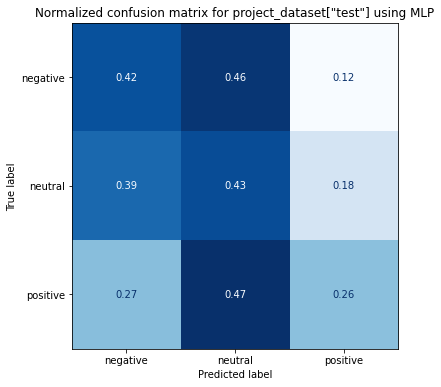




Classification report for project_dataset["test"] using MLP
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.45      0.42      0.44       504
     neutral       0.28      0.43      0.34       384
    positive       0.46      0.26      0.34       413

    accuracy                           0.38      1301
   macro avg       0.40      0.37      0.37      1301
weighted avg       0.40      0.38      0.38      1301

---------------------------------------------------------------------------


In [ ]:
loaded_mlp = load(working_dir + "/best_models/mlp.joblib")
y_preds_t = loaded_mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using MLP")

### 2.3.2 Training a classifier using fine tuning

2.3.2.1 Defining functions required for training a classifier by fine-tuning a transformer model

In [ ]:
# Defining the performance metrics that will be used to evaluate our model's performance during fine-tuning
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
  loss_val = loss_fct(torch.from_numpy(pred.predictions).to(device), torch.from_numpy(labels).to(device))
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  prec = precision_score(labels, preds, average="weighted")
  rec = recall_score(labels, preds, average="weighted")
  return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1, "loss": loss_val}


def model_init():
  dropout_val = 0.3
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)
      dropout_val = prev_hp["dropout"]
      print("Found previously searched dropout value: ", dropout_val)
  except:
    print("No previous dropout value found. Using default setting of", dropout_val)

  if model_checkpoint == "distilbert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             dropout=dropout_val,
                                                             attention_dropout=dropout_val,
                                                             qa_dropout=dropout_val).to(device))
  elif model_checkpoint == "bert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             attention_probs_dropout_prob=dropout_val,
                                                             hidden_dropout_prob=dropout_val,
                                                             classifier_dropout=dropout_val).to(device))

def compute_objective(metrics):
  return metrics["eval_loss"]

2.3.2.2 Defining the project trainer class

In [ ]:
class ProjectTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(output_dir=model_output_dir,
                                  evaluation_strategy="steps",
                                  logging_strategy="steps",
                                  eval_steps=500,
                                  disable_tqdm=False,
                                  logging_dir=model_output_dir + "/logs",
                                  save_total_limit=1,
                                  load_best_model_at_end=True)

trainer = ProjectTrainer(args=training_args,
                            tokenizer=tokenizer,
                            train_dataset=dataset_encoded["train"],
                            eval_dataset=dataset_encoded["valid"],
                            model_init=model_init,
                            compute_metrics=compute_metrics)

No previous dropout value found. Using default setting of 0.3


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.3,
  "dim": 768,
  "dropout": 0.3,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.3,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading we

2.3.2.3 Performing hyperparameter tuning for the model

In [ ]:
def project_hyperparameter_tuning():

  hp_search_space = dict()
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)
    plr = prev_hp["learning_rate"]

    hp_search_space= {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(plr * 0.1, plr * 10),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }
  except:
    hp_search_space = {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }

  if model_checkpoint == "distilbert-base-uncased":
    hp_search_space["dropout"] = tune.uniform(0.1, 0.3)
    hp_search_space["attention_dropout"] = tune.uniform(0.1, 0.3)
    hp_search_space["qa_dropout"] = tune.uniform(0.1, 0.3)
  elif model_checkpoint == "bert-base-uncased":
    hp_search_space["attention_probs_dropout_prob"] = tune.uniform(0.1, 0.3)
    hp_search_space["hidden_dropout_prob"] = tune.uniform(0.1, 0.3)
    hp_search_space["classifier_dropout"] = tune.uniform(0.1, 0.3)

  best_trial = None
  try:
    best_trial = trainer.hyperparameter_search(hp_space=lambda _: hp_search_space,
                                             compute_objective=compute_objective,
                              direction="minimize",
                              backend="ray",
                              n_trials=2,
                              search_alg=HyperOptSearch(metric="objective", mode="min"),
                              scheduler=ASHAScheduler(metric="objective", mode="min"),
                              local_dir=model_output_dir + "/ray_asha_results_bert",
                              log_to_file=True)

    save_best_model = False
    if "objective" not in hp_search_space:
      save_best_model = True
    if ("objective" in hp_search_space) and (hp_search_space["objective"] > best_trial.objective):
      print("New best hyperparameters found.")
      save_best_model = True

    if save_best_model == True:
      save_model_dir = working_dir + "/best_models/" + model_checkpoint
      for f in os.listdir(save_model_dir):
          os.remove(os.path.join(save_model_dir, f))

      best_run_dir = model_output_dir + "/run-" + best_trial.run_id
      best_model_checkpoint = sorted(os.listdir(best_run_dir))[-1]
      copy_model_dir = os.path.join(best_run_dir, best_model_checkpoint)

      for f in os.listdir(copy_model_dir):
        shutil.copy(os.path.join(copy_model_dir, f), save_model_dir)
      shutil.make_archive(save_model_dir, 'zip', save_model_dir)

      print("Saved model associated with the new best hyperparameters in this directory: ", save_model_dir)
      print("Download the zip file to use the model later.")
    else:
      print("Could not find better hyperparameters in this search.")

    for f in os.listdir(model_output_dir):
      path = os.path.join(model_output_dir, f)
      try:
        shutil.rmtree(path)
      except OSError:
        os.remove(path)
    print("Cleared all files from this hyperparameter search from the following directory: ", model_output_dir)

    hp_values = best_trial.hyperparameters
    hp_values["objective"] = best_trial.objective
    hp_values_json = json.dumps(hp_values)
    with open(model_output_dir + "/model_hp_values.json", "w") as f:
      f.write(hp_values_json)
    print("New hyperparameters written to " + model_output_dir + "/model_hp_values.json")
  except:
    print("Hyperparameter search did not complete successfully.")

  return best_trial

current_best_trial = project_hyperparameter_tuning()
print("Best hyperparameters from this search: ", current_best_trial)

 11%|█         | 616/5564 [02:10<15:02,  5.48it/s]


== Status ==
Current time: 2022-04-12 06:31:13 (running for 00:02:22.39)
Memory usage on this node: 6.2/25.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -1.0605850219726562
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/12.42 GiB heap, 0.0/6.21 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/output-distilbert-base-uncased/ray_asha_results_bert/_objective_2022-04-12_06-28-51
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+---------------------+----------+----------------+---------------------+-----------+-----------------+--------------------+-------------------------------+--------------+----------------+-------------+
| Trial name          | status   | loc            |   attention_dropout |   dropout |   learning_rate |   num_train_epochs |   per_device_train_batch_size |   qa_dropout |   weight_decay |   objective |
|---------------------+----------+----------------+---------------------+-

 12%|█▏        | 644/5564 [02:15<15:00,  5.46it/s]


== Status ==
Current time: 2022-04-12 06:31:18 (running for 00:02:27.41)
Memory usage on this node: 6.2/25.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -1.0605850219726562
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/12.42 GiB heap, 0.0/6.21 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/output-distilbert-base-uncased/ray_asha_results_bert/_objective_2022-04-12_06-28-51
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+---------------------+----------+----------------+---------------------+-----------+-----------------+--------------------+-------------------------------+--------------+----------------+-------------+
| Trial name          | status   | loc            |   attention_dropout |   dropout |   learning_rate |   num_train_epochs |   per_device_train_batch_size |   qa_dropout |   weight_decay |   objective |
|---------------------+----------+----------------+---------------------+-

 12%|█▏        | 655/5564 [02:17<14:51,  5.50it/s]
2022-04-12 06:31:20,850	WARNING tune.py:596 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2022-04-12 06:31:20 (running for 00:02:29.43)
Memory usage on this node: 6.2/25.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -1.0605850219726562
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/12.42 GiB heap, 0.0/6.21 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/output-distilbert-base-uncased/ray_asha_results_bert/_objective_2022-04-12_06-28-51
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+---------------------+----------+----------------+---------------------+-----------+-----------------+--------------------+-------------------------------+--------------+----------------+-------------+
| Trial name          | status   | loc            |   attention_dropout |   dropout |   learning_rate |   num_train_epochs |   per_device_train_batch_size |   qa_dropout |   weight_decay |   objective |
|---------------------+----------+----------------+---------------------+-

 12%|█▏        | 656/5564 [02:17<15:00,  5.45it/s]
2022-04-12 06:31:21,066	ERROR tune.py:635 -- Trials did not complete: [_objective_d1a7f3de, _objective_d47f48e6]
2022-04-12 06:31:21,067	INFO tune.py:639 -- Total run time: 149.75 seconds (149.42 seconds for the tuning loop).
2022-04-12 06:31:21,069	WARNING tune.py:644 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Hyperparameter search did not complete successfully.
Best hyperparameters from this search:  BestRun(run_id='d1a7f3de', objective=1.0605850219726562, hyperparameters={'per_device_train_batch_size': 16, 'learning_rate': 2.645123755319578e-05, 'weight_decay': 0.3, 'num_train_epochs': 4, 'dropout': 0.28650539637184935, 'attention_dropout': 0.14277373313533553, 'qa_dropout': 0.20007419287264938})


In [ ]:
save_model_dir = working_dir + "/best_models/" + model_checkpoint
shutil.make_archive(save_model_dir, 'zip', save_model_dir)

2.3.2.4 Training the model with the last best set of hyperparameters found.

This function is written because it was observed that sometimes the hyperparameter tuning phase does not complete successfully due to memory related issues. This function allows us work with any improved hyperparameters found during unsuccessful hyperparameter tuning attempts by manually going through the logs.

In [ ]:
def train_with_last_best_hyperparameters():
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      hp_values = json.load(f)
    print("Set trainer.args using previous hyperparamter search results.")
  except:
    hp_values = dict()
    hp_values["learning_rate"] = 1.5544610095816334e-05
    hp_values["num_train_epochs"] = 2
    hp_values["per_device_train_batch_size"] = 64
    hp_values["seed"] = 25
    hp_values["weight_decay"] = 0.1
    hp_values["dropout"] = 0.12078133498900412
    print("No previous hyperparameter search results found. Manually setting the hyperparameter values.")

  for n, v in hp_values.items():
    if n == "seed":
      v = int(v)
    setattr(trainer.args, n, v)
  setattr(trainer.args, "callbacks", [EarlyStoppingCallback(early_stopping_patience=3)])

  trainer.train()

  model_save_path = model_output_dir +  "/best_model"
  tokenizer.save_pretrained(model_save_path)
  trainer.save_model(model_save_path)

  train_losses = list()
  validation_losses = list()

  for entry in trainer.state.log_history:
    if "loss" in entry:
      train_losses.append(entry["loss"])
    if "eval_loss" in entry:
      validation_losses.append(entry["eval_loss"])

  plt.plot(train_losses, color="blue")
  plt.plot(validation_losses, color="red")
  plt.ylim(-0.05, 2)
  plt.xlabel("Steps")
  plt.ylabel("loss")
  plt.legend(["train_loss", "validation_loss"])
  plt.title("Loss every 500 steps")
  plt.show()

train_with_last_best_hyperparameters()

No previous hyperparameter search results found. Manually setting the hyperparameter values.
No previous dropout value found. Using default setting of 0.3


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.3,
  "dim": 768,
  "dropout": 0.3,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.3,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading we

Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

2.3.2.5 Generating results

Provides the confusion matrix and classification report for validation data and test data of the project

In [ ]:
y_valid = np.array(dataset_encoded["valid"]["label"])
validation_predictions_all = trainer.predict(dataset_encoded["valid"])
y_preds_v = np.argmax(validation_predictions_all.predictions, axis=1)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using finetuned " + model_checkpoint)

y_test = np.array(dataset_encoded["test"]["label"])
test_predictions_all = trainer.predict(dataset_encoded["test"])
y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using finetuned " + model_checkpoint)

2.3.2.5 Loading saved model and testing performance on test data

In [ ]:
def evaluate_test_data_using_saved_model(dataset):
  # Load model
  try:
    model_load_path = working_dir +  "/best_models/" + model_checkpoint 
    loaded_tokenizer = AutoTokenizer.from_pretrained(model_load_path)
    loaded_m = (AutoModelForSequenceClassification.from_pretrained(model_load_path, num_labels=3).to(device))
    trainer = ProjectTrainer(model=loaded_m)

    dataset_encoded = encode_dataset(loaded_tokenizer, dataset)
    y_test = np.array(dataset_encoded["label"])
    labels = dataset.features["label"].names

    test_predictions_all = trainer.predict(dataset_encoded)
    y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
    print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using finetuned " + model_checkpoint)
  except FileNotFoundError:
    print("Could not load a model from the provided path.")
  except Exception as e:
    print("Could not complete the opration because of the following error: ", e)
evaluate_test_data_using_saved_model(project_dataset["test"])

# 3. LSTM and BiLSTM Section

#3.1 Preparing Data for LSTM and BiLSTM


3.1.1 Loading

In [3]:
training_data_path = os.getcwd() + "/train_dataset_processed.csv"
testing_data_path = os.getcwd() + "/test_dataset_processed.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
training_data_df = pd.read_csv(training_data_path, names = ["Sentiment", "Tweet"])
testing_data_df = pd.read_csv(testing_data_path, names = ["Sentiment", "Tweet"])

In [5]:
training_data_df

,Sentiment,Tweet
0,1,Well done HK Government for heeding concerns o...
1,2,Solidarity &amp; good luck with everyone start...
2,1,Having private health insurance doesn't mean a...
3,0,"While President, Trump signed a check to cover..."
4,1,"Trump on Omar/Tlaib: ""Any Jewish people that v..."
...,...,...
27802,0,“He’s not Jill Stein. He’s not Ross Perot. He’...
27803,1,Alexander Calder?! Kim Taehyung did you said A...
27804,2,Looking back and admiring our child-self is a ...
27805,0,"the only porn im watching is food porn , other..."


3.1.2 Preprocessing 

In [6]:
def remove_punctuations(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text, flags=re.MULTILINE)
    return text.lower()

def remove_stop_words(text):
    text = ' '.join([word for word in text.split(" ") if not word in STOP_WORDS])
    return text

In [7]:
training_data_df["Tweet"] = training_data_df["Tweet"].apply(str).apply(remove_punctuations).apply(remove_stop_words)
testing_data_df["Tweet"] = testing_data_df["Tweet"].apply(remove_punctuations).apply(remove_stop_words)   

print("Training Data Length: ", len(training_data_df["Tweet"]))
print("Testing Data Length: ", len(testing_data_df["Tweet"]))


Training Data Length:  27807
Testing Data Length:  1301


1    12368
0     9023
2     6416
Name: Sentiment, dtype: int64


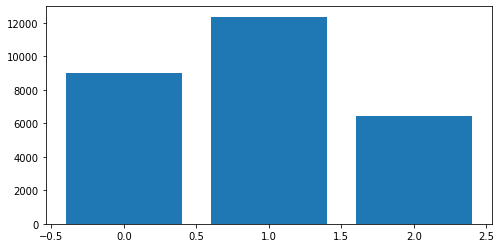

In [8]:
count = training_data_df['Sentiment'].value_counts()
plt.figure(figsize=(8, 4))
plt.bar(count.index, count.values)
print(training_data_df['Sentiment'].value_counts())

3.1.3 Creating vocabulary

In [9]:
from collections import Counter 

#TRAINING data
training_merged_text = ' '.join(training_data_df["Tweet"])
training_words = training_merged_text.split()

#Using counter method to count all the words
training_word_count = Counter(training_words)
training_words_total = len(training_words)
training_sorted_words = training_word_count.most_common(training_words_total)

#TESTING data
testing_merged_text = ' '.join(testing_data_df["Tweet"])
testing_words = testing_merged_text.split()
testing_word_count = Counter(testing_words)
testing_words_total = len(testing_words)
testing_sorted_words = testing_word_count.most_common(testing_words_total)

In [10]:
assert isinstance(training_sorted_words, list), "Expected training sorted list to be a list"
assert isinstance(training_word_count, Counter), "Expected training sorted count to be a Counter"
assert training_words_total == 436506, "Unexpected testing words total"
assert isinstance(testing_sorted_words, list), "Expected testing sorted list to be a list"
assert isinstance(testing_word_count, Counter), "Expected training sorted count to be a Counter"
assert testing_words_total == 21531, "Unexpected testing words total"

3.1.4 Convert vocabulary into integer corresponding integer form

In [11]:
training_vocabulary_to_integer = {w:i+1 for i, (w,c) in enumerate(training_sorted_words)}
testing_vocabulary_to_integer = {w:i+1 for i, (w,c) in enumerate(testing_sorted_words)}

In [12]:
assert isinstance(training_vocabulary_to_integer, dict), "Expected integer training vocabulary to be a dictionary"
assert len(training_vocabulary_to_integer) == 43461, "Unexpected trainig vocabulary total"
assert isinstance(testing_vocabulary_to_integer, dict), "Expected integer testing vocabulary to be a dictionary"
assert len(testing_vocabulary_to_integer) == 7627, "Unexpected testing words total"

3.1.5 Mapping tweets to integer format based on the generated voccabulary

In [13]:
training_tweets = training_data_df["Tweet"]

training_integer_mapping_array = []
for tweet in training_tweets:
    training_integer_array = [training_vocabulary_to_integer[words] for words in tweet.split()]
    training_integer_mapping_array.append(training_integer_array)   

training_data_df["Integer Mapping"] = training_integer_mapping_array


testing_tweets = testing_data_df["Tweet"]

testing_integer_mapping_array = []
for tweet in testing_tweets:
    testing_integer_array = [testing_vocabulary_to_integer[words] for words in tweet.split()]
    testing_integer_mapping_array.append(testing_integer_array)   

testing_data_df["Integer Mapping"] = testing_integer_mapping_array


In [14]:
assert isinstance(training_data_df["Integer Mapping"][0], list), "Expected integer form of training tweets to be a list"
assert isinstance(training_data_df["Integer Mapping"][0][0], int), "Expected training content to contain int values"

assert isinstance(testing_data_df["Integer Mapping"][0], list), "Expected integer form of testing tweets vocabulary to be a list"
assert isinstance(testing_data_df["Integer Mapping"][0][0], int), "Expected testing content to contain int values"

3.1.6 Analyse tweet length

In [15]:
training_labels = np.array(training_data_df["Sentiment"])
testing_labels = np.array(testing_data_df["Sentiment"])

In [16]:
print(len(training_integer_mapping_array))
print(len(testing_integer_mapping_array))

27807
1301


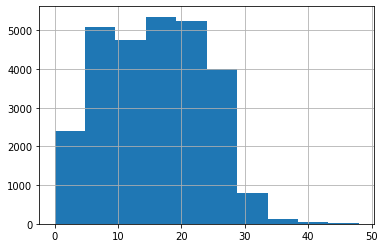

count    27807.000000
mean        15.697702
std          7.828130
min          0.000000
25%          9.000000
50%         16.000000
75%         22.000000
max         48.000000
dtype: float64

In [17]:
training_tweet_integer_len = [len(x) for x in training_data_df["Integer Mapping"]]
pd.Series(training_tweet_integer_len).hist()
plt.show()
pd.Series(training_tweet_integer_len).describe()

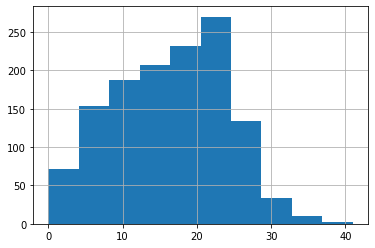

count    1301.000000
mean       16.549577
std         7.345540
min         0.000000
25%        11.000000
50%        17.000000
75%        22.000000
max        41.000000
dtype: float64

In [18]:
testing_tweet_integer_len = [len(x) for x in testing_data_df["Integer Mapping"]]
pd.Series(testing_tweet_integer_len).hist()
plt.show()
pd.Series(testing_tweet_integer_len).describe()

3.1.7 Removing tweets with zero length

In [19]:
training_integer_mapping_array = [training_integer_mapping_array[i] for i, length in enumerate(training_tweet_integer_len) if length > 0 ]
training_labels = [ training_labels[i] for i, length in enumerate(training_tweet_integer_len) if length > 0 ]

testing_integer_mapping_array = [testing_integer_mapping_array[i] for i, length in enumerate(testing_tweet_integer_len) if length > 0 ]
testing_labels = [ testing_labels[i] for i, length in enumerate(testing_tweet_integer_len) if length > 0 ]

In [20]:
print(len(training_integer_mapping_array))
print(len(testing_integer_mapping_array))

27778
1300


In [21]:
assert len(training_integer_mapping_array) == 27778, "Unexpected training mapping array length"
assert len(testing_integer_mapping_array) == 1300, "Unexpected testing mapping array length"

3.1.8 Padding integer form of tweets

In [22]:
def padding(integer_mapping_array, sequence_length):
    features = np.zeros((len(integer_mapping_array), sequence_length), dtype = int)
    for i, tweet_int in enumerate(integer_mapping_array):
        tweet_integer_len = len(tweet_int)
        
        if tweet_integer_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length - tweet_integer_len))
            new = zeroes + tweet_int
        elif tweet_integer_len > sequence_length:
            new = tweet_int[0:sequence_length]
        
        features[i,:] = np.array(new)
    
    return features

In [23]:
training_sequence_length = max(len(length) for length in training_integer_mapping_array)
training_integer_mapping_array = padding(training_integer_mapping_array, training_sequence_length)

testing_sequence_length = max(len(length) for length in testing_integer_mapping_array)
testing_integer_mapping_array = padding(testing_integer_mapping_array, testing_sequence_length)

X_test = testing_integer_mapping_array
y_test = testing_labels
y_test = np.array(y_test)

3.1.9 Splitting data into training and validation data

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_integer_mapping_array, training_labels, test_size=0.3, train_size=0.7)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [25]:
assert isinstance(X_train, np.ndarray), "Expected training features to be numpy array"
assert isinstance(y_train, np.ndarray), "Expected training labels to be numpy array"
assert isinstance(X_valid, np.ndarray), "Expected validation features to be numpy array"
assert isinstance(y_valid, np.ndarray), "Expected validation labels to be numpy array"

3.1.10 Converting datasets into PyTorch data loader objects.

In [26]:
#Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

#Batch Size
batch_size = 50

#Creating data loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True, pin_memory =True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True, pin_memory =True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, pin_memory =True)

In [27]:
assert isinstance(train_data, torch.utils.data.dataset.TensorDataset), "Expected training data to be a TensorDataset"
assert len(train_loader) == len(train_data)//batch_size, "Unexpected training data loader size"
assert isinstance(valid_data, torch.utils.data.dataset.TensorDataset), "Expected validation data to be a TensorDataset"
assert len(valid_loader) == len(valid_data)//batch_size, "Unexpected validation data loader size"
assert isinstance(test_data, torch.utils.data.dataset.TensorDataset), "Expected testing data to be a TensorDataset"
assert len(test_loader) == len(test_data)//batch_size, "Unexpected testing data loader size"

3.1.11 Obtaining one batch of training data

In [28]:
training_data_iterator = iter(train_loader)
x_train_sample, y_train_sample = training_data_iterator.next()
print('Sample input size: ', x_train_sample.size()) 
print('Sample input: \n', x_train_sample)
print()
print('Sample label size: ', y_train_sample.size())
print('Sample label: \n', y_train_sample)

Sample input size:  torch.Size([50, 48])
Sample input: 
 tensor([[    0,     0,     0,  ...,     0, 32914,  1624],
        [    0,     0,     0,  ...,   148,   168,  7966],
        [    0,     0,     0,  ...,    67,  1431,   525],
        ...,
        [    0,     0,     0,  ...,     0,     0,    41],
        [    0,     0,     0,  ...,   590,   794,    25],
        [    0,     0,     0,  ...,    34,   415,   283]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2,
        2, 2])


3.1.12 Computing class weights to rectify unbalanced classes

In [29]:
classes = np.unique(training_data_df["Sentiment"])
class_weights=compute_class_weight(class_weight='balanced', classes=classes, y=training_data_df["Sentiment"])
class_weights=torch.tensor(class_weights, dtype=torch.float)

In [30]:
assert isinstance(class_weights, torch.Tensor), "Expected class weights to be a Tensor"
assert len(class_weights) == 3, "Expected class weights to be 3"

#3.2 LSTM model

In [31]:
class LSTMModel(nn.Module):
   def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_layers, drop_prob=0.5):
        
        '''Model initialization - setting up layers'''
        super(LSTMModel, self).__init__()

        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        #Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.6)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
   def forward(self, x, hidden):
        ''' Performing forward pass on input and hidden state '''

        batch_size = x.size(0)
        x = x.long()

        #Embeddings with dropout
        embeddings = self.dropout(self.embedding(x))

        #LSTM
        lstm_out, hidden = self.lstm(embeddings, hidden)

        #Stacking up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #Dropout
        out = self.dropout(lstm_out)

        #Fully Connected
        out = self.fc(out)

        #Reshaping 
        output = out.view(batch_size, -1, output_size)

        #Getting last batch of labels
        output = output[:, -1] 
        
        #Return last output with the hidden state
        return output, hidden
    
    
   def init_hidden(self, batch_size):
        ''' Initializing hidden state '''
        
        #Two tensors of size num_layers * batch_size * hidden_dim are initialized to zero
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


3.2.1 Training function

In [32]:
def train(model, epochs, batch_size, train_loader, criterion, clip, valid_loader):
  counter = 0
  model.train().to(device)

  train_losses = list()
  validation_losses = list()

  #Training loop upto epoch
  for epoch in range(epochs): 

      #Hidden state initialization
      hidden = model.init_hidden(batch_size)

      #Batch wise looping
      for inputs, labels in train_loader:
          
          counter += 1
          
          #Recreating variables for the hidden state to avoid backpropagate
          hidden = tuple([each.data for each in hidden])

          #Setting the gradients of optimized torch
          model.zero_grad()

          inputs = inputs.to(device)
          labels = labels.to(device)

          #Getting the prediction from the model
          prediction, hidden = model(inputs, hidden)
          
          #Calculating training Loss
          loss = criterion(prediction.squeeze(), labels.long())

          loss.backward()
          
          #Gradient Clipping
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()

          #Calculating validation loss for each epoch
          if counter % print_step == 0:

              #Hidden state initialization
              valid_hidden_state = model.init_hidden(batch_size)
              val_losses = []

              model.eval()

              for inputs, labels in valid_loader:

                  #Recreating variables for the hidden state to avoid backpropagate
                  valid_hidden_state = tuple([each.data for each in valid_hidden_state])

                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  #Getting the prediction from the model
                  prediction, valid_hidden_state = model(inputs, valid_hidden_state)

                  #Calculating validation loss for each epoch
                  valid_loss = criterion(prediction.squeeze(), labels.long())
                  val_losses.append(valid_loss.item())

              model.train()
              
              train_losses.append(loss.item())
              validation_losses.append(np.mean(val_losses))

              print("Epoch: {}/{}...".format(epoch + 1, epochs),
                    "Step: {}...".format(counter),
                    "Training Loss: {:.6f}...".format(loss.item()),
                    "Validation Loss: {:.6f}".format(np.mean(validation_losses)))
                          
  return train_losses, validation_losses

3.2.2 Setting up hyperparameters

In [33]:
vocab_size = len(training_vocabulary_to_integer) + 1      #Vocabulary size for embedding layer
output_size = 3                                           #Output size
embedding_dim = 200                                       #Embedding dimension
hidden_dim = 256                                          #Hidden dimension
num_layers = 2                                            #Number of layers
lstm_model = LSTMModel(vocab_size, output_size, embedding_dim, hidden_dim, num_layers).to(device)       #LSTM Object

criterion = nn.CrossEntropyLoss(class_weights).to(device)                       #Categorical cross entropy

counter = 0
epochs = 100                                              #Number of epochs
print_step = 100
clip = 10                                                 #For gradient clipping
lr = 1e-5                                                 #Learning Rate
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)   #Optimization Algorithm

In [34]:
assert isinstance(lstm_model, LSTMModel), "Expected model to be LSTMModel"
assert isinstance(lstm_model.lstm, nn.LSTM), "Expected lstm layer to be nn.LSTM"
assert isinstance(lstm_model.embedding, nn.Embedding), "Expected embedding layer to be nn.Embedded"
assert isinstance(lstm_model.lstm, nn.LSTM), "Expected lstm layer to be nn.LSTM"
assert isinstance(lstm_model.dropout, nn.Dropout), "Expected dropout layer to be nn.Dropout"
assert isinstance(lstm_model.fc, nn.Linear), "Expected fc layer to be nn.Linear"

3.2.3 Training phase

In [51]:
lstm_train_losses, lstm_validation_losses = train(lstm_model, epochs, batch_size, train_loader, criterion, clip, valid_loader);

Epoch: 1/100... Step: 100... Training Loss: 1.095103... Validation Loss: 1.098239
Epoch: 1/100... Step: 200... Training Loss: 1.113927... Validation Loss: 1.098046
Epoch: 1/100... Step: 300... Training Loss: 1.098866... Validation Loss: 1.097891
Epoch: 2/100... Step: 400... Training Loss: 1.098330... Validation Loss: 1.097789
Epoch: 2/100... Step: 500... Training Loss: 1.105965... Validation Loss: 1.097661
Epoch: 2/100... Step: 600... Training Loss: 1.100460... Validation Loss: 1.097565
Epoch: 2/100... Step: 700... Training Loss: 1.094729... Validation Loss: 1.097447
Epoch: 3/100... Step: 800... Training Loss: 1.102232... Validation Loss: 1.097320
Epoch: 3/100... Step: 900... Training Loss: 1.103451... Validation Loss: 1.097267
Epoch: 3/100... Step: 1000... Training Loss: 1.100492... Validation Loss: 1.097227
Epoch: 3/100... Step: 1100... Training Loss: 1.099078... Validation Loss: 1.097123
Epoch: 4/100... Step: 1200... Training Loss: 1.102043... Validation Loss: 1.097078
Epoch: 4/100.

3.2.4 Training and Validation plot

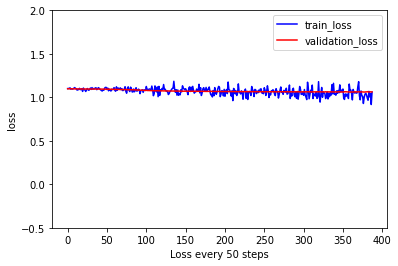

In [40]:
plt.plot(lstm_train_losses, color="blue")
plt.plot(lstm_validation_losses, color="red")
plt.ylim(-0.5, 2)
plt.xlabel("Loss every 50 steps")
plt.ylabel("loss")
plt.legend(["train_loss", "validation_loss"])
plt.show()

3.2.5 Saving LSTM Model

In [39]:
from joblib import dump, load

lstm_save_filename = os.getcwd() + "/lstm_model.joblib"
dump(lstm_model, lstm_save_filename)

['/contentlstm_model.joblib']

3.2.6 Testing function

In [31]:
def testing(model, test_loader, batch_size):
  test_losses = []
  y_pred = []
  y_true = []

  num_correct = 0

  #Hidden state initialization
  hidden = model.init_hidden(batch_size)
  model.eval()

  #Batch wise looping
  for inputs, labels in test_loader:

      #Recreating variables for the hidden state to avoid backpropagate
      hidden = tuple([each.data for each in hidden])

      inputs, labels = inputs.to(device), labels.to(device)
      
      output, hidden = model(inputs, hidden)
      
      #Calculating test loss
      test_loss = criterion(output.squeeze(), labels.long())
      test_losses.append(test_loss.item())

      
      #Converting probabilities to output classse
      pred = torch.argmax(output ,dim=1, keepdim=True)
      y_pred.extend(pred.cpu().detach().numpy())        #Saving predicted values
      y_true.extend(np.array(labels.long().cpu()))      #Saving true values

  return y_pred, y_true

3.2.7 Testing Phase

In [37]:
lstm_y_pred, lstm_y_true = testing(lstm_model, test_loader, batch_size = batch_size)

3.2.8 Results

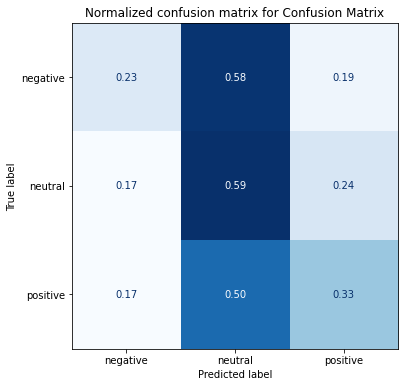



Classification report for Confusion Matrix
---------------------------------------------------------------------------
Accuracy: 36.77%
Precision: 40.29%
Recall: 36.77%
F1 score: 35.64%
---------------------------------------------------------------------------





In [43]:
print_classification_report(lstm_y_pred, lstm_y_true, title = "LSTM")

#3.3. BiLSTM model

In [36]:
class BiLSTMModel(nn.Module):
   def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_layers, drop_prob=0.6):
        
        '''Model initialization - setting up layers'''
        super(BiLSTMModel, self).__init__()

        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        #Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #BiLSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, 
                            dropout=drop_prob, batch_first=True, bidirectional=True)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        
   def forward(self, x, hidden):
        ''' Performing forward pass on input and hidden state '''

        batch_size = x.size(0)
        x = x.long()

        #Embeddings with dropout
        embeddings = self.dropout(self.embedding(x))

        #BiLSTM
        lstm_out, hidden = self.lstm(embeddings, hidden)

        #Stacking up BiLSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)
        
        #Dropout
        out = self.dropout(lstm_out)

        #Fully Connected
        out = self.fc(out)

        #Reshaping 
        output = out.view(batch_size, -1, output_size)

        #Getting last batch of labels
        output = output[:, -1] 
        
        #Return last output with the hidden state
        return output, hidden
    
    
   def init_hidden(self, batch_size):
        ''' Initializing hidden state '''
        
        #Two tensors of size num_layers * batch_size * hidden_dim are initialized to zero
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers * 2, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.num_layers * 2, batch_size, self.hidden_dim).zero_())
        
        return hidden


3.3.1 Setting up hyperparameters

In [44]:
vocab_size = len(training_vocabulary_to_integer) + 1      #Vocabulary size for embedding layer
output_size = 3                                           #Output size
embedding_dim = 200                                       #Embedding dimension
hidden_dim = 256                                          #Hidden dimension
num_layers = 2                                            #Number of layers
bilstm_model = BiLSTMModel(vocab_size, output_size, embedding_dim, hidden_dim, num_layers).to(device)       #LSTM Object

criterion = nn.CrossEntropyLoss(class_weights).to(device)                       #Categorical cross entropy

counter = 0
epochs = 100                                              #Number of epochs
print_step = 100
clip = 10                                                 #For gradient clipping
lr = 1e-6                                                 #Learning Rate
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=lr)   #Optimization Algorithm

In [45]:
assert isinstance(bilstm_model, BiLSTMModel), "Expected model to be LSTMModel"
assert isinstance(bilstm_model.lstm, nn.LSTM), "Expected lstm layer to be nn.LSTM"
assert isinstance(bilstm_model.embedding, nn.Embedding), "Expected embedding layer to be nn.Embedded"
assert isinstance(bilstm_model.lstm, nn.LSTM), "Expected lstm layer to be nn.LSTM"
assert isinstance(bilstm_model.dropout, nn.Dropout), "Expected dropout layer to be nn.Dropout"
assert isinstance(bilstm_model.fc, nn.Linear), "Expected fc layer to be nn.Linear"

3.3.2 Training Phase

In [46]:
bilstm_train_losses, bilstm_validation_losses = train(bilstm_model, epochs, batch_size, train_loader, criterion, clip, valid_loader);

Epoch: 1/100... Step: 100... Training Loss: 1.096493... Validation Loss: 1.099005
Epoch: 1/100... Step: 200... Training Loss: 1.094739... Validation Loss: 1.098984
Epoch: 1/100... Step: 300... Training Loss: 1.094470... Validation Loss: 1.098973
Epoch: 2/100... Step: 400... Training Loss: 1.095654... Validation Loss: 1.098958
Epoch: 2/100... Step: 500... Training Loss: 1.096563... Validation Loss: 1.098950
Epoch: 2/100... Step: 600... Training Loss: 1.097238... Validation Loss: 1.098945
Epoch: 2/100... Step: 700... Training Loss: 1.098591... Validation Loss: 1.098937
Epoch: 3/100... Step: 800... Training Loss: 1.095086... Validation Loss: 1.098931
Epoch: 3/100... Step: 900... Training Loss: 1.111622... Validation Loss: 1.098929
Epoch: 3/100... Step: 1000... Training Loss: 1.101676... Validation Loss: 1.098927
Epoch: 3/100... Step: 1100... Training Loss: 1.110032... Validation Loss: 1.098926
Epoch: 4/100... Step: 1200... Training Loss: 1.097575... Validation Loss: 1.098924
Epoch: 4/100.

3.3.3 Training and Validation plot

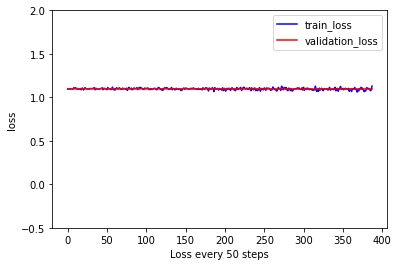

In [47]:
plt.plot(bilstm_train_losses, color="blue")
plt.plot(bilstm_validation_losses, color="red")
plt.ylim(-0.5, 2)
plt.xlabel("Loss every 50 steps")
plt.ylabel("loss")
plt.legend(["train_loss", "validation_loss"])
plt.show()

3.3.3 Saving BiLSTM model

In [50]:
from joblib import dump, load

bilstm_save_filename = os.getcwd() + "/bilstm_model.joblib"
dump(bilstm_model, bilstm_save_filename)

['/content/bilstm_model.joblib']

3.3.4 Testing Phase

In [51]:
bilstm_y_pred, bilstm_y_true = testing(bilstm_model, test_loader, batch_size = batch_size)

3.3.5 Results

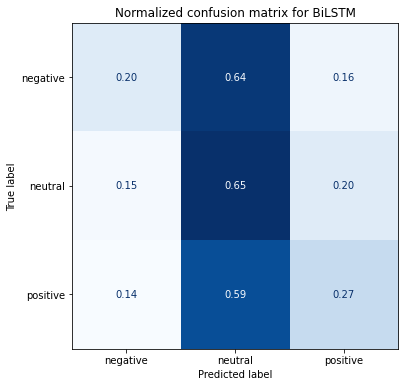



Classification report for BiLSTM
---------------------------------------------------------------------------
Accuracy: 35.62%
Precision: 40.48%
Recall: 35.62%
F1 score: 33.60%
---------------------------------------------------------------------------





In [52]:
print_classification_report(bilstm_y_pred, bilstm_y_true, title = "BiLSTM")